In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install mtcnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 8.3 MB/s eta 0:00:00


In [3]:
import cv2
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from google.colab.patches import cv2_imshow
from sklearn.preprocessing import LabelEncoder
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [5]:
BASE_INPUT_PATH = "/content/drive/MyDrive/SP24-CSEN240-2/Project"
TRAIN_DATA_PATH = BASE_INPUT_PATH + "/Train"
VALIDATION_DATA_PATH = BASE_INPUT_PATH + "/Validation"
TEST_DATA_PATH = BASE_INPUT_PATH + "/Test"
GROUP_NUMBER = "9" # TODO
ADDITIONAL_FILES_PATH = BASE_INPUT_PATH + "/Temp/Group-%s" % GROUP_NUMBER
OUTPUT_PATH = BASE_INPUT_PATH +"/Prediction"

Augmentation Function

In [6]:
from typing import List
from PIL import Image
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
def augment_image1(
    image: np.ndarray,
    num_augs: int = 20
) -> List[Image.Image]:
    image1 = image
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    aug_images = []

    image = image.reshape((1,) + image.shape)
    for i, batch in enumerate(datagen.flow(image, batch_size=1)):
        aug_image = batch[0].astype('uint8')
        pil_image = Image.fromarray(aug_image)

        aug_images.append(pil_image)
        if len(aug_images) == num_augs:
            break
    original = Image.fromarray(image1)
    aug_images.append(original)
    return aug_images

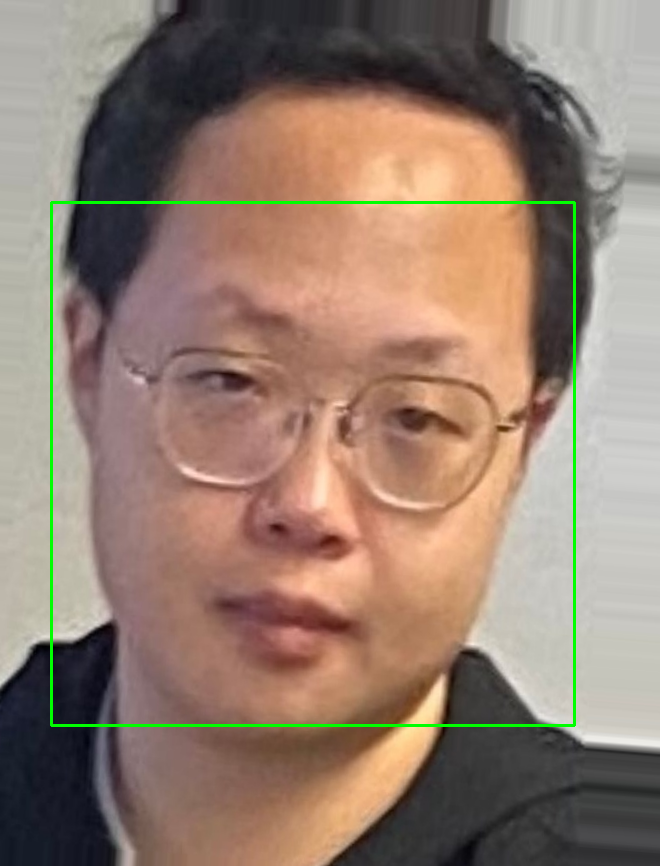

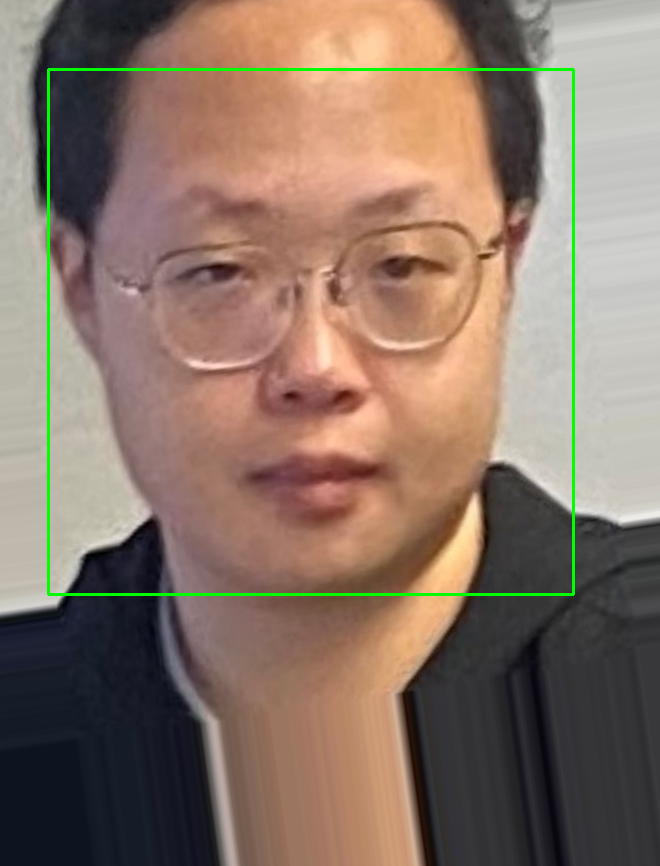

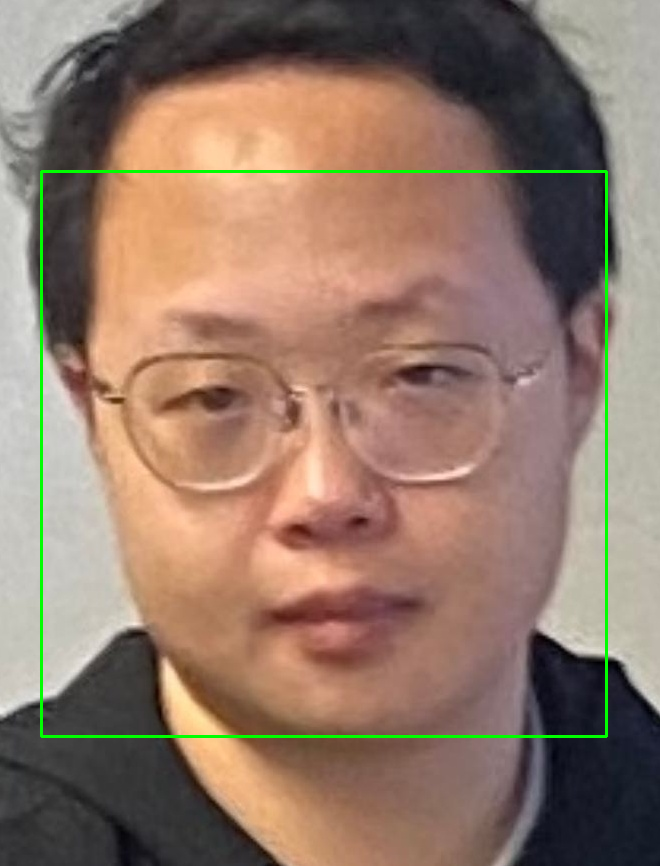

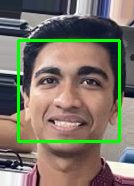

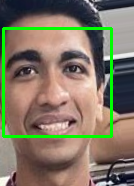

In [ ]:
train_labels_df = pd.read_csv(os.path.join(TRAIN_DATA_PATH, "labels.txt"), delimiter=" ", header=None)
train_labels_df.columns = ["file_number", "person_name"]
# Create a dictionary to map file numbers to person names
train_label_mapping = train_labels_df.set_index('file_number')['person_name'].to_dict()

# Read labels for validation set
# Function to load images and labels
def load_images_and_labels(folder, label_mapping):
    images = []
    labels = []
    for filename in os.listdir(folder):
        file_number = filename.split('.')[0]
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            images.append(img)
            labels.append(file_number)
    return images, labels

# Function to Augment images
def augment_images(images, labels, num_augs_per_image=5):
    augmented_images = []
    augmented_labels = []
    for image, label in zip(images, labels):
        augmented_faces = augment_image1(image, num_augs_per_image)
        for aug_face in augmented_faces:
            aug_face_array = np.array(aug_face)
            augmented_images.append(aug_face_array)
            augmented_labels.append(label)
    return augmented_images, augmented_labels

# detect faces using Haar cascade classifer
def detect_faces(images, labels, label_mapping):
    face_images = []
    face_labels = []
    print_counter = 5
    for image, label in zip(images, labels):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=9, minSize=(30, 30))
        for (x, y, w, h) in faces:
            face = image[y:y+h, x:x+w]
            face = cv2.resize(face, (128, 128))
            face_images.append(face)
            face_labels.append(label_mapping[int(label)])
            if print_counter > 0:
                cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
                cv2_imshow(image)
                print_counter -= 1
            cv2.waitKey(0)
    return np.array(face_images), np.array(face_labels)

# Load Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Detect faces and get labels for training set
train_images, train_labels = load_images_and_labels(TRAIN_DATA_PATH, train_label_mapping)
augmented_train_images, augmented_train_labels = augment_images(train_images, train_labels, num_augs_per_image=5)
train_images, train_labels = detect_faces(augmented_train_images, augmented_train_labels, train_label_mapping)

# Detect faces and get labels for validation set
def load_images_and_labels_with_face_detection(folder, label_mapping):
    images = []
    labels = []
    print_counter = 5
    for filename in os.listdir(folder):
        file_number = filename.split('.')[0]  # Assuming the filename is in the format "number.jpg"
        # print(filename,"file_number: ", file_number)
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=9, minSize=(30, 30))
            for (x, y, w, h) in faces:
                face = img[y:y+h, x:x+w]
                face = cv2.resize(face, (128, 128))
                images.append(face)
                label = label_mapping[int(file_number)]
                labels.append(label)
                cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
                # if print_counter > 0:
                #   cv2_imshow(img)
                #   print_counter -= 1
                cv2.waitKey(0)
    return np.array(images), np.array(labels)


# Encode the labels

# opencv BGR channel format and plt reads images as RGB channel format

Validation Stuff

In [ ]:
val_labels_df = pd.read_csv(os.path.join(VALIDATION_DATA_PATH, "labels.txt"), delimiter=" ", header=None)
val_labels_df.columns = ["file_number", "person_name"]

val_label_mapping = val_labels_df.set_index('file_number')['person_name'].to_dict()

# Detect faces and get labels for validation set
val_images, val_labels = load_images_and_labels_with_face_detection(VALIDATION_DATA_PATH, val_label_mapping)




Lable Encoding

In [ ]:
#all_labels = np.concatenate((train_labels, val_labels))

# Train the LabelEncoder on all labels
le = LabelEncoder()

# Encode train and validation labels
train_labels_encoded = le.fit_transform(train_labels)
val_labels_encoded = le.transform(val_labels)
#print(val_labels, val_labels_encoded)

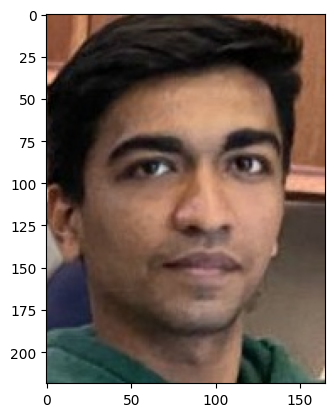

In [ ]:
for filename in os.listdir(TRAIN_DATA_PATH):
    img = cv2.imread(os.path.join(TRAIN_DATA_PATH, filename))
    if img is None:
        continue
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
#train_images = cv2.cvtColor(train_images, cv2.COLOR_BGR2RGB)
#plt.imshow(train_images) # RGB

In [ ]:
from mtcnn.mtcnn import MTCNN

detector = MTCNN()
results = detector.detect_faces(img_rgb)

1/1 [==============================] - 0s 266ms/step


In [ ]:
results

[{'box': [23, 27, 116, 157],
  'confidence': 0.9999998211860657,
  'keypoints': {'left_eye': (62, 90),
   'right_eye': (117, 88),
   'nose': (96, 122),
   'mouth_left': (68, 150),
   'mouth_right': (114, 150)}}]

In [ ]:
x,y,w,h = results[0]['box']

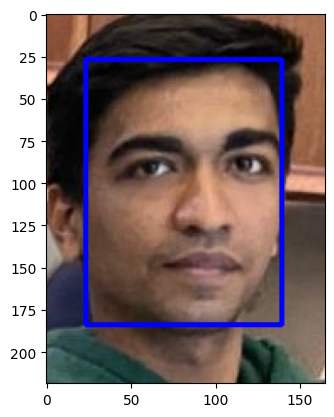

In [ ]:
img_rgb = cv2.rectangle(img_rgb, (x,y), (x+w, y+h), (0,0,255), 2)
plt.imshow(img_rgb)

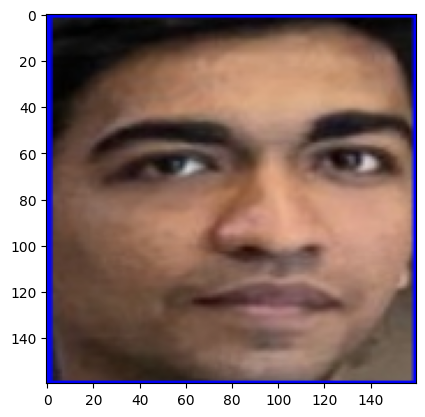

In [ ]:
my_face = img_rgb[y:y+h, x:x+w]
#Facenet takes as input 160x160
my_face = cv2.resize(my_face, (160,160))
plt.imshow(my_face)

array([[[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [ 10,  10, 188],
        ...,
        [  7,   9,  16],
        [  5,   6, 115],
        [  0,   0, 255]],

       ...,

       [[  0,   0, 255],
        [  0,   0, 255],
        [ 10,   9, 189],
        ...,
        [119, 105,  92],
        [ 70,  62, 159],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  9,   9, 190],
        ...,
        [118, 102,  94],
        [ 69,  60, 161],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]]], dtype=uint8)
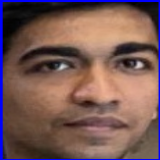

In [ ]:
my_face

# Automate the preprocessing


In [ ]:
class FACELOADING:
    def __init__(self, directory):
        self.directory = directory
        self.target_size = (160,160)
        self.X = []
        self.Y = []
        self.detector = MTCNN()
    def XY(self):
        self.X.extend(train_images)
        self.Y.extend(train_labels)
        return np.asarray(self.X), np.asarray(self.Y)

    def UV(self):
        self.X.extend(val_images)
        self.Y.extend(val_labels)
        return np.asarray(self.X), np.asarray(self.Y)



    def plot_images(self):
        plt.figure(figsize=(18,16))
        for num,image in enumerate(self.X):
            ncols = 3
            nrows = len(self.Y)//ncols + 1
            plt.subplot(nrows,ncols,num+1)
            plt.imshow(image)
            plt.axis('off')

In [ ]:
def load_jpg_files(directory):
    # Ensure the directory is a string, bytes, or os.PathLike
    if not isinstance(directory, (str, bytes, os.PathLike)):
        raise ValueError("The provided directory path is not a valid type.")

    # List all files in the directory
    try:
        files = os.listdir(directory)
    except Exception as e:
        print(f"Error accessing the directory: {e}")
        return []

    # Filter out the JPG files and convert to full paths
    jpg_files = [os.path.join(directory, file) for file in files if file.lower().endswith('.jpg')]

    return jpg_files
TRAIN_DATA_PATH = '/content/drive/MyDrive/mlcontent/Training/'
jpg_files = load_jpg_files(TRAIN_DATA_PATH)
faceloading = FACELOADING(TRAIN_DATA_PATH)
facewrecking=FACELOADING(VALIDATION_DATA_PATH)
X, Y = faceloading.XY()
U, V= facewrecking.UV()

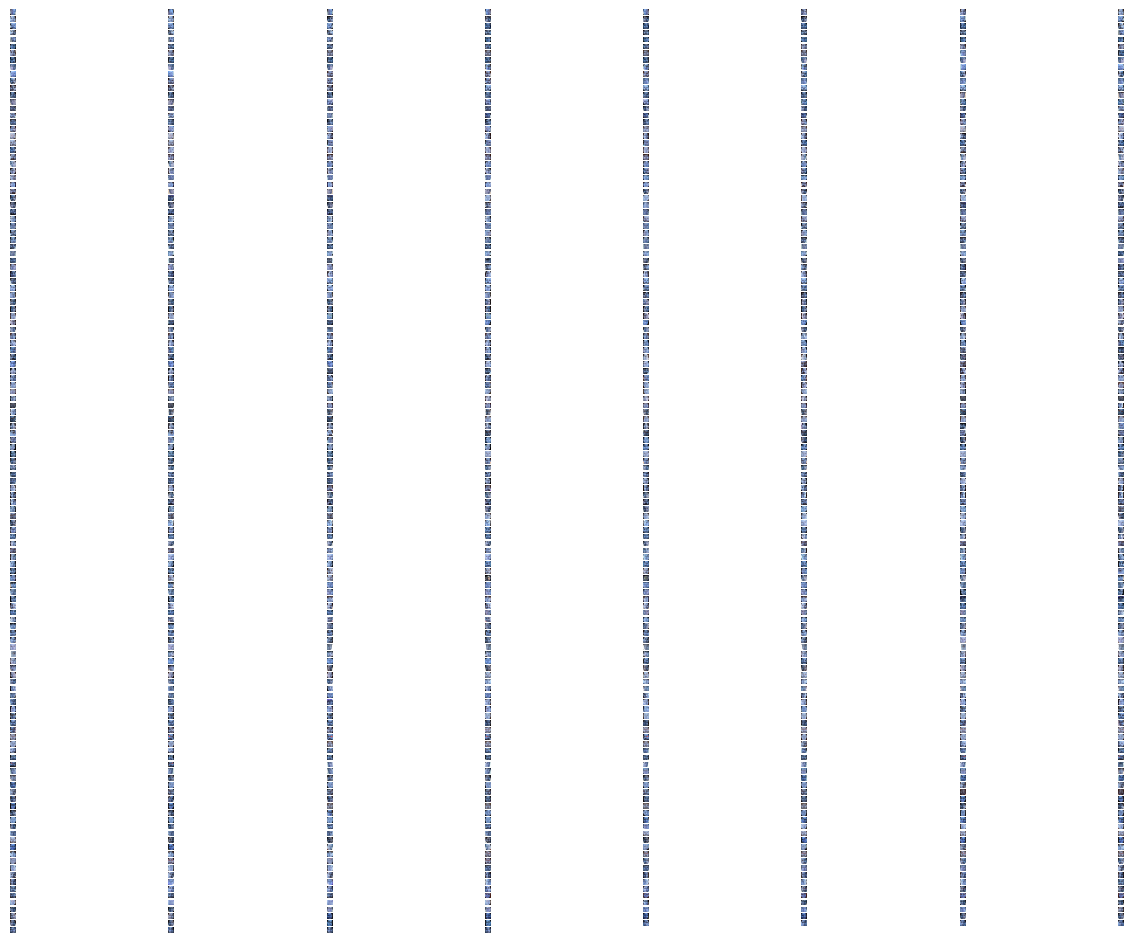

In [ ]:
plt.figure(figsize=(16,12))
for num,image in enumerate(X):
    ncols = 8
    nrows = len(Y)//ncols + 1
    plt.subplot(nrows,ncols,num+1)
    plt.imshow(image)
    plt.axis('off')

# FaceNet part

In [ ]:
!pip install keras-facenet

  Preparing metadata (setup.py) ... done
  Created wheel for keras-facenet: filename=keras_facenet-0.3.2-py3-none-any.whl size=10369 sha256=16a8bc120024db2f20caa2f57a7583ad160ec80e559bc3e2baf3553efba560fe
  Stored in directory: /root/.cache/pip/wheels/1d/d8/a9/85cf04ea29321d2afcb82c0caaafdca9195385f9d68cbc7185
Successfully built keras-facenet


In [ ]:
from keras_facenet import FaceNet
embedder = FaceNet()

def get_embedding(face_img):
    face_img = face_img.astype('float32') # 3D(160x160x3)
    face_img = np.expand_dims(face_img, axis=0)
    # 4D (Nonex160x160x3)
    yhat= embedder.embeddings(face_img)
    return yhat[0] # 512D image (1x1x512)

In [ ]:
EMBEDDED_X = []

for img in X:
    EMBEDDED_X.append(get_embedding(img))

EMBEDDED_X = np.asarray(EMBEDDED_X)


1/1 [==============================] - 0s 154ms/step


In [ ]:
EMBEDDED_U = []

for img in U:
    EMBEDDED_U.append(get_embedding(img))

EMBEDDED_U = np.asarray(EMBEDDED_U)

1/1 [==============================] - 0s 111ms/step


In [ ]:
np.savez_compressed('faces_embeddings_done_4classes.npz', EMBEDDED_X, Y)

# SVM model


In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(Y)
Y = encoder.transform(Y)
V= encoder.transform(V)

Text(0, 0.5, '22')

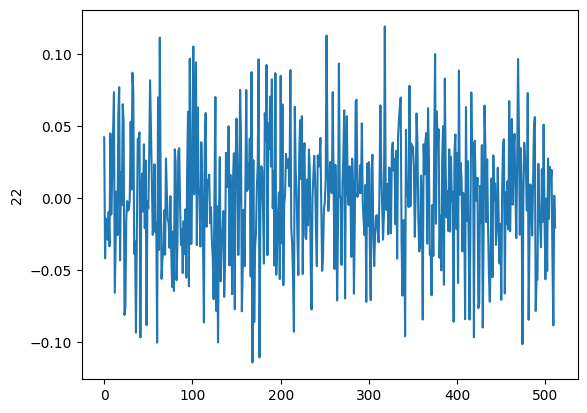

In [ ]:
plt.plot(EMBEDDED_X[0])
plt.ylabel(Y[0])

In [ ]:
Y

array([22, 22, 22, ..., 23, 23, 23])

In [ ]:
V

array([ 3, 33,  0, 31, 33,  3,  0, 33, 33,  0,  2,  2,  0,  2, 33,  2,  5,
        1,  1, 10, 33,  8, 34, 21,  1, 31,  2,  8, 27, 34,  0, 24,  6, 16,
       16, 24, 21, 13, 13, 10, 22, 18, 27, 22, 20, 15, 14, 20, 23, 20, 24,
       24, 18, 14, 15, 23, 14, 23, 21, 13, 14, 25,  8, 29, 17, 23, 29, 12,
       13, 20,  8, 11, 22, 28, 14, 19, 11, 20, 17, 17, 19,  9, 25, 28, 28,
       17,  9, 23, 16, 25, 25, 26, 11, 10, 10, 10, 18, 16, 28, 18, 11,  9,
        9, 25,  9, 19, 26, 11, 26, 16, 17, 18,  4, 19,  1, 32,  7,  3, 29,
        7, 32, 27,  4, 29, 30,  1,  7,  4, 33, 30, 24, 33, 26,  5,  5,  7,
        5,  5,  5,  3,  3, 30, 30, 31, 31,  6,  6, 30, 32,  6, 32, 31])

In [ ]:
from sklearn.model_selection import train_test_split

#X_train, X_test, Y_train, Y_test = train_test_split(EMBEDDED_X, Y, shuffle=True, random_state=17)

In [ ]:
from sklearn.svm import SVC
model = SVC(kernel='rbf', probability=True)
model.fit(EMBEDDED_X, Y)

SVC(probability=True)

In [ ]:
ypreds_train = model.predict(EMBEDDED_X)
ypreds_val = model.predict(EMBEDDED_U)

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(Y, ypreds_train)

0.9990636704119851

In [ ]:
accuracy_score(V,ypreds_val)

0.993421052631579

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

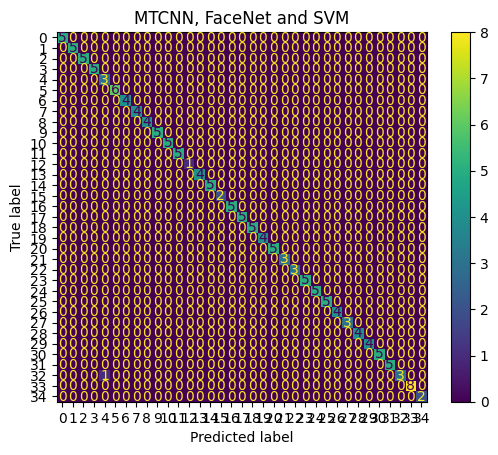

In [ ]:
cm = confusion_matrix(V, ypreds_val)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('MTCNN, FaceNet and SVM')
plt.show()

